In [1]:
%logstop
%logstart -rtq ~/.logs/wqu_4_intro_statistics.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

Logging hadn't been started.


C:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\logging.py:130: UserWarning: Couldn't start log: [Errno 2] No such file or directory: 'C:\\Users\\User/.logs/DS_Intro_Statistics.py'
  warn("Couldn't start log: %s" % sys.exc_info()[1])


# Introduction to Statistics

Statistics is the study of how random variables behave in aggregate. It is also the use of that behavior to make inferences and arguments. While much of the math behind statistical calculations is rigorous and precise, its application to real data often involves making imperfect assumptions. In this notebook we'll review some fundamental statistics and pay special attention to the assumptions we make in their application.

## Hypothesis Testing and Parameter Estimator

We often use statistics to describe groups of people or events; for example we compare the current temperature to the *average* temperature for the day or season or we compare a change in stock price to the *volatility* of the stock (in the language of statistics, volatility is called **standard deviation**) or we might wonder what the *average* salary of a data scientist is in a particular country. All of these questions and comparisons are rudimentary forms of statistical inference. Statistical inference often falls into one of two categories: hypothesis testing or parameter estimator.

Examples of hypothesis testing are:
- Testing if an increase in a stock's price is significant or just random chance
- Testing if there is a significant difference in salaries between employees with and without advanced degrees
- Testing whether there is a significant correlation between the amount of money a customer spent at a store and which advertisements they'd been shown

Examples of parameter estimation are:
- Estimating the average annual return of a stock
- Estimating the variance of salaries for a particular job across companies
- Estimating the correlation coefficient between annual advertising budget and annual revenue

We'll explore the processes of statistical inference by considering the example of salaries with and without advanced degrees.

**Exercise:** Decide for each example given in the first sentence whether it is an example of hypothesis testing or parameter estimation.

## Estimating the Mean

Suppose that we know from a prior study that employees with advanced degrees in the USA make on average $70k. To answer the question "do people without advanced degrees earn significantly less than people with advanced degrees?" we must first estimate how much people without advanced degrees earn on average.

To do that, we will have to collect some data. Suppose we take a representative, unbiased sample of 1000 employed adults without advanced degrees and learn their salaries. To estimate the mean salary of people without advanced degrees, we simply calculate the mean of this sample:

$$ \overline X = \frac{1}{n} \sum_{k=1}^n X_k. $$

Let's write some code that will simulate sampling some salaries for employees without advanced degrees.

In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [3]:
salaries = sp.stats.lognorm(1, loc=20, scale=25)

def plot_sample(dist):
    def plotter(size):
        X = dist.rvs(size=size)
        ys, bins, _ = plt.hist(X, bins=20, density=True)
        plt.ylim([0, ys.max() / (ys * (bins[1] - bins[0])).sum() * 1.25])
        plt.axvline(dist.mean(), color='r', label='true mean')
        plt.axvline(X.mean(), color='g', label='sample mean')
        plt.plot(np.arange(20, 100, .01), salaries.pdf(np.arange(20, 100, .01)), 'k--')
        plt.legend()

    return plotter

In [4]:
sample_size_slider = IntSlider(min=10, max=200, step=10, value=10, description='sample size')
interact(plot_sample(salaries), size=sample_size_slider)

interactive(children=(IntSlider(value=10, description='sample size', max=200, min=10, step=10), Output()), _do…

<function __main__.plot_sample.<locals>.plotter(size)>

## Standard Error of the Mean

Notice that each time we run the code to generate the plot above, we draw a different sample. While the "true" mean remains fixed, the sample mean changes as we draw new samples. In other words, our estimate (the sample mean) of the true mean is noisy and has some error. How noisy is it? How much does it typically differ from the true mean? *What is the **standard deviation** of the sample mean from the true mean*?

Let's take many samples and make a histogram of the sample means to visualize the typical difference between the sample mean and the true mean.

In [6]:
def plot_sampling_dist(dist):
    def plotter(sample_size):
        means = np.array([dist.rvs(size=sample_size).mean() for _ in range(300)]) - dist.mean()
        plt.hist(means, bins=20, density=True, label='sample means')

        # plot central limit theorem distribution
        Xs = np.linspace(means.min(), means.max(), 1000)
        plt.plot(Xs, sp.stats.norm.pdf(Xs, scale=np.sqrt(dist.var()/sample_size)), 'k--',
                 label='central limit theorem')

        plt.legend()

    return plotter

In [9]:
sample_size_slider = IntSlider(min=10, max=50, step=10, value=10, description='sample_size')
interact(plot_sampling_dist(salaries), sample_size=sample_size_slider)

interactive(children=(IntSlider(value=10, description='sample_size', max=50, min=10, step=10), Output()), _dom…

<function __main__.plot_sampling_dist.<locals>.plotter(sample_size)>

As we increase the size of our samples, the distribution of sample means comes to resemble a normal distribution. In fact this occurs regardless of the underlying distribution of individual salaries. This phenomenon is described by the Central Limit Theorem, which states that as the sample size increases, the sample mean will tend to follow a normal distribution with a standard deviation

$$ \sigma_{\overline X} = \sqrt{\frac{\sigma^2}{n}}.$$

This quantity is called the **standard error**, and it quantifies the standard deviation of the sample mean from the true mean.

**Exercise:** In your own words, explain the difference between the standard deviation and the standard error of salaries in our example.

### Answers
standard deviation measuress the error between the true mean and the average, while standard error means the number of errors per frequency of the mean.

## Hypothesis Testing and z-scores

Now that we can calculate how much we may typically expect the sample mean to differ from the true mean by random chance, we can perform a **hypothesis test**. In hypothesis testing, we assume that the true mean is a known quantity. We then collect a sample and calculate the difference between the sample mean and the assumed true mean. If this difference is large compared to the standard error (i.e. the typical difference we might expect to arise from random chance), then we conclude that the true mean is unlikely to be the value that we had assumed. Let's be more precise with out example.

1. Suppose that we know from a prior study that employees with advanced degrees in the USA make on average \$70k. Our **null hypothesis** will be that employees without advanced degrees make the same salary: $H_0: \mu = 70$. We will also choose a threshold of significance for our evidence. In order to decide that our null hypothesis is wrong, we must find evidence that would have less than a certain probability $\alpha$ of occurring due to random chance.

In [10]:
mu = 70

2. Next we collect a sample of salaries from $n$ employees without advanced degrees and calculate the mean of the sample salaries. Below we'll sample 100 employees.

In [11]:
sample_salaries = salaries.rvs(size=100)
print('Sample mean: {}'.format(sample_salaries.mean()))

Sample mean: 65.28741653575246


3. Now we compare the difference between the sample mean and the assumed true mean to the standard error. This quantity is called a **z-score**.

$$ z = \frac{\overline X - \mu}{\sigma / \sqrt{n}} $$

In [12]:
z = (sample_salaries.mean() - mu) / np.sqrt(salaries.var() / sample_salaries.size)
print('z-score: {}'.format(z))

z-score: -0.8722171199331676


4. The z-score can be used with the standard normal distribution (due to the Central Limit Theorem) to calculate the probability that the difference between the sample mean and the null hypothesis is due only to random chance. This probability is called a **p-value**.

In [13]:
p = sp.stats.norm.cdf(z)
print('p-value: {}'.format(p))

p-value: 0.19154497082671584


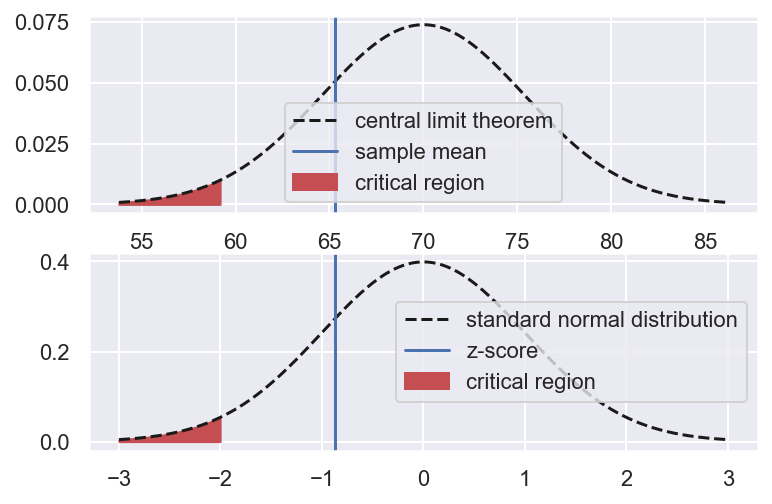

In [14]:
plt.subplot(211)
stderr = np.sqrt(salaries.var() / sample_salaries.size)
Xs = np.linspace(mu - 3*stderr, mu + 3*stderr, 1000)
clt = sp.stats.norm.pdf(Xs, loc=mu, scale=stderr)
plt.plot(Xs, clt, 'k--',label='central limit theorem')
plt.axvline(sample_salaries.mean(), color='b', label='sample mean')
plt.fill_between(Xs[Xs < mu - 2*stderr], 0, clt[Xs < mu - 2*stderr], color='r', label='critical region')
plt.legend()

plt.subplot(212)
Xs = np.linspace(-3, 3, 1000)
normal = sp.stats.norm.pdf(Xs)
plt.plot(Xs, normal, 'k--', label='standard normal distribution')
plt.axvline(z, color='b', label='z-score')
plt.fill_between(Xs[Xs < -2], 0, normal[Xs < -2], color='r', label='critical region')
plt.legend()

5. If our p-value is less than $\alpha$ then we can reject the null hypothesis; since we found evidence that was very unlikely to arise by random chance, it must be that our initial assumption about the value of the true mean was wrong.

This is a very simplified picture of hypothesis testing, but the central idea can be a useful tool outside of the formal hypothesis testing framework. By calculating the difference between an observed quantity and the value we would expect, and then comparing this difference to our expectation for how large the difference might be due to random chance, we can quickly make intuitive judgments about quantities that we have measured or calculated.

## Confidence Intervals

We can also use the Central Limit Theorem to help us perform parameter estimation. Using our sample mean, we estimate the average salary of employees without advanced degrees. However, we also know that this estimate deviates somewhat from the true mean due to the randomness of our sample.
Therefore we should put probabilistic bounds on our estimate. We can again use the standard error to help us calculate this probability.

Confidence interval (95%) for average salary: (54.48 76.09)


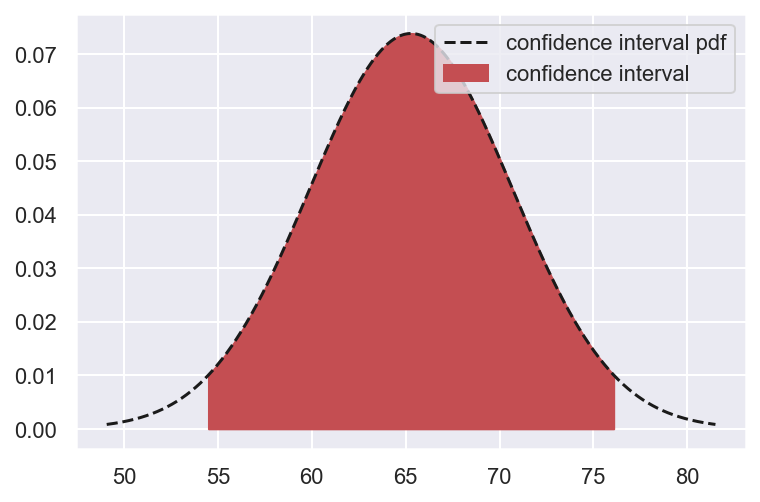

In [15]:
print("Confidence interval (95%) for average salary: ({:.2f} {:.2f})".format(sample_salaries.mean() - 2 * stderr,
                                                                             sample_salaries.mean() + 2 * stderr))

Xs = np.linspace(sample_salaries.mean() - 3*stderr,
                 sample_salaries.mean() + 3*stderr,
                 1000)

ci = sp.stats.norm.pdf(Xs, loc=sample_salaries.mean(), scale=stderr)

plt.plot(Xs, ci, 'k--',label='confidence interval pdf')
plt.fill_between(Xs[(Xs > sample_salaries.mean() - 2*stderr) & (Xs < sample_salaries.mean() + 2*stderr)],
                 0,
                 clt[(Xs > sample_salaries.mean() - 2*stderr) & (Xs < sample_salaries.mean() + 2*stderr)],
                 color='r', label='confidence interval')
plt.legend(loc = 'upper right')

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*
**Edited by Chisomloius**